In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from src.algs import *
from src.projections import *
from src.phantom_creator import *


<h4>Semilunar phantom creation</h4>

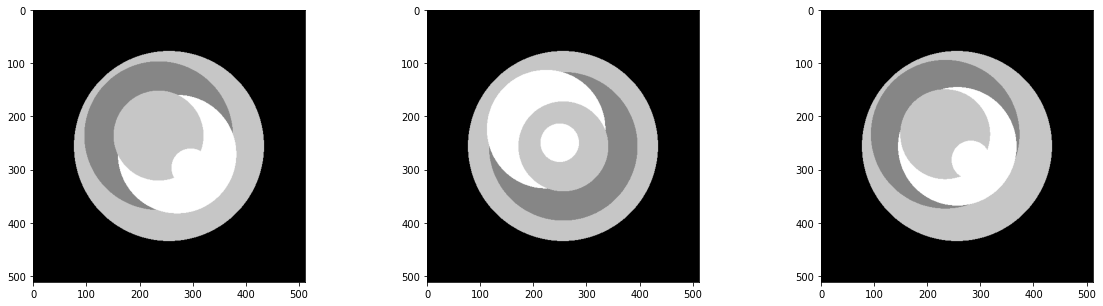

In [2]:
semilunars = create_semilunars(512, n=3, overlap=True, seed=0, img_name="phantoms/semilunars/semilunar")
fig, ax = plt.subplots(1, len(semilunars), figsize=(20,5))
for i in range(len(semilunars)):
    ax[i].imshow(semilunars[i], cmap="Greys_r")

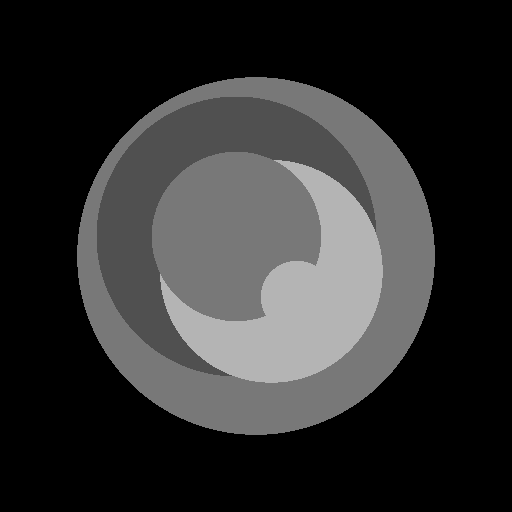

In [3]:
Image.fromarray(semilunars[0])

<h4>Measurement parameters for DART</h4>

In [4]:
# ,easurement parameters
n_projections = 30
n_detectors = 512
det_spacing = 1
noise_factor = None
# dart paramenters
dart_iters = 10
p = 0.9
rec_alg = 'SART_CUDA'
rec_iters = 1000

# open phantom
img = np.array(Image.open("phantoms/semilunars/semilunar_0.png"), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare all the data
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape

gray_lvls = np.unique(img).astype(np.float16)
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
# make measurements
angles = np.linspace(0, np.pi, n_projections)
projector_id, sino_id, sinogram = project_from_2D(phantom_id=phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                        n_detectors, angles)

# instanciate DART
dart = DART(gray_levels=gray_lvls, p=p, rec_shape=img.shape,
        proj_geom=proj_geom, projector_id=projector_id,
        sinogram=sinogram)

<br/>
<h4>Segmentation step</h4>

Initial gray levels: [0, 50.0, 130.0, 255]
Gray levels in segmented image: [ 40  60 200]
Segmented image:


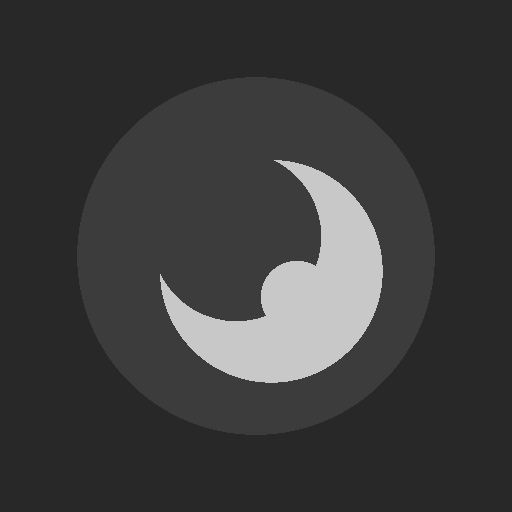

In [5]:
# defining new gray levels
gray_levels = [40, 60, 200]
dart.gray_levels = gray_levels
# update DART thresholds
dart.thresholds = dart.update_gray_thresholds()
# Segmentation step
segmented_img = dart.segment(img)
print(f"Initial gray levels: {dart.thresholds}")
print(f"Gray levels in segmented image: {np.unique(segmented_img)}")
print("Segmented image:")
Image.fromarray(segmented_img)

<br/>
<h4>Boundary pixels</h4>

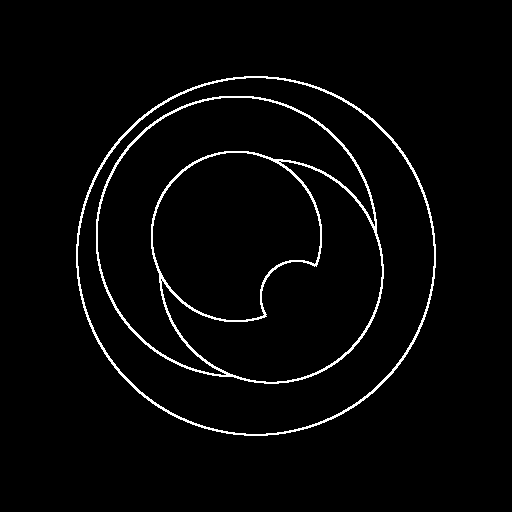

In [6]:
boundaries = dart.boundary_pixels(img)
Image.fromarray(boundaries)

<br/>
<h4>Free pixels</h4>

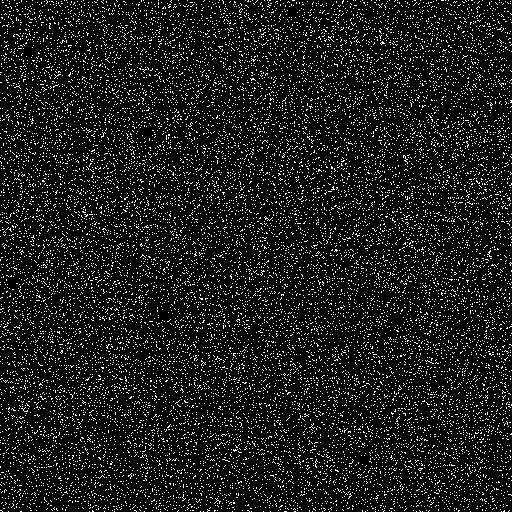

In [7]:
free_pixels = dart.free_pixels()
Image.fromarray(free_pixels)

<br/>
<h4>Total free pixels</h4>

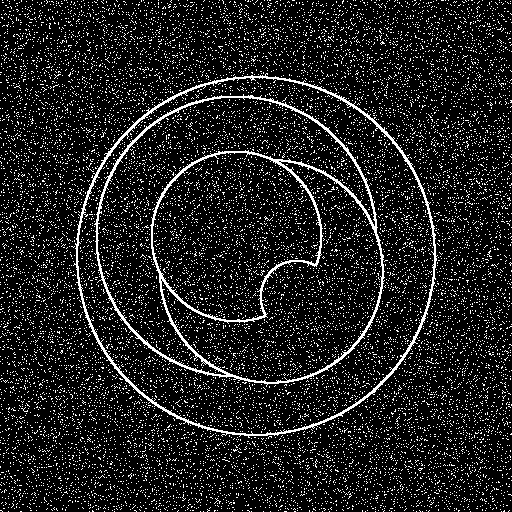

In [8]:
all_free_pixels = np.logical_or(boundaries,free_pixels)
Image.fromarray(all_free_pixels)

<br>
<h4>
Running DART
</h4>

Mean absolute pixel error: 0.42533189058303833


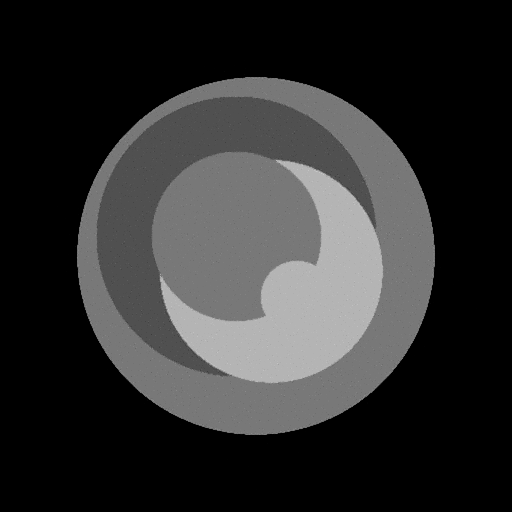

In [9]:
# fix gray levels and thresholds
dart.gray_levels = np.unique(img).astype(np.float16)
dart.thresholds = dart.update_gray_thresholds()
# run the algorithm
rec = dart.run(iters=dart_iters, rec_alg=rec_alg, rec_iter=rec_iters)
print(f"Mean absolute pixel error: {np.abs(img - rec).mean()}")
Image.fromarray(rec.astype(np.uint8))